In [8]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import os

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Resize((48,48)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

dataset=ImageFolder("Emotions/train",transform=transform)
print(dataset.classes)



['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [2]:

# Collecting the images of a type and shuffling them

from collections import defaultdict
import random

class_indices=defaultdict(list)

for index,label in enumerate(dataset.targets):
    class_indices[label].append(index)

for label,index in enumerate(class_indices):
    random.shuffle(class_indices[label])


In [3]:
# Selecting small subsets
reduced_indices={}
for label,index in enumerate(class_indices):
    subset_count=int(len(class_indices[label]))
    reduced_indices[label]=class_indices[label][:subset_count]
reduced_indices

# Flattening out the indices into one list
import itertools
final_indices=list(itertools.chain.from_iterable(reduced_indices.values()))


In [4]:
# Creating a Subset of the indices
from torch.utils.data import Subset
subset_dataset=Subset(dataset,final_indices)

# Loading the data
from torch.utils.data import DataLoader
train_loader=DataLoader(subset_dataset,batch_size=32,shuffle=True)



In [5]:
import torch.nn as nn

class EmotionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1)
        self.maxpool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.relu=nn.ReLU()
        self.batchnorm1=nn.BatchNorm2d(32)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm2=nn.BatchNorm2d(64)
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.batchnorm3=nn.BatchNorm2d(128)
        self.conv4=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm4=nn.BatchNorm2d(256)
        self.linear1=nn.Linear(in_features=2304,out_features=512)
        self.dropout=nn.Dropout(0.5)
        self.linear2=nn.Linear(in_features=512,out_features=7)
        
    def forward(self,x):
        y=self.conv1(x)
        y=self.batchnorm1(y)
        y=self.relu(y)
        y=self.maxpool(y)
        y=self.conv2(y)
        y=self.batchnorm2(y)
        y=self.relu(y)
        y=self.maxpool(y)
        y=self.conv3(y)
        y=self.batchnorm3(y)
        y=self.relu(y)
        y=self.maxpool(y)
        y=self.conv4(y)
        y=self.batchnorm4(y)
        y=self.relu(y)
        y=self.maxpool(y)
        y=torch.flatten(y,1)
        y=self.linear1(y)
        y=self.relu(y)
        y=self.dropout(y)
        y=self.linear2(y)

        return y
    

        


In [6]:
CNN=EmotionCNN().to("mps")
criterion=nn.CrossEntropyLoss()
optim=torch.optim.Adam(CNN.parameters(),lr=0.001)



In [7]:
import tqdm

num_epochs=20

for i in tqdm.tqdm(range(num_epochs)):
    CNN.train()
    running_loss=0
    correct_predictions=0
    for images,label in train_loader:
        images,label=images.to('mps'),label.to('mps')
        optim.zero_grad()
        output=CNN(images)
        loss=criterion(output,label)
        loss.backward()
        optim.step()
        running_loss+=loss.item()
        preds=torch.argmax(output,dim=1)
        correct_predictions += (preds == label).sum().item()

    avg_train_loss=running_loss/len(train_loader)
    total_samples = len(train_loader.dataset)

    train_accuracy=correct_predictions/total_samples
    print(f'Average Training Loss in epoch{i+1} = {avg_train_loss}')
    print(f'Average Training Accuracy in epoch{i+1} = {train_accuracy}')


  0%|          | 0/20 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [83]:
torch.save(CNN.state_dict(), "emotion_model.pth")


In [86]:
# Test 
test_dataset = ImageFolder("Emotions/test", transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

CNN.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    total_loss = 0
    for imgs, labels in test_loader:
        imgs, labels = imgs.to('mps'), labels.to('mps')
        output = CNN(imgs)
        loss = criterion(output, labels)
        total_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

avg_test_loss = total_loss / len(test_loader)
test_accuracy = total_correct / total_samples
print(f'Average Training Loss = {avg_train_loss}')
print(f'Average Training Accuracy = {train_accuracy}')


NameError: name 'avg_train_loss' is not defined

In [87]:
# Evaluating Confusion Matrix

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(all_labels,all_preds)

In [88]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Facial Emotion Recognition')
plt.show()


NameError: name 'cm' is not defined

<Figure size 800x600 with 0 Axes>

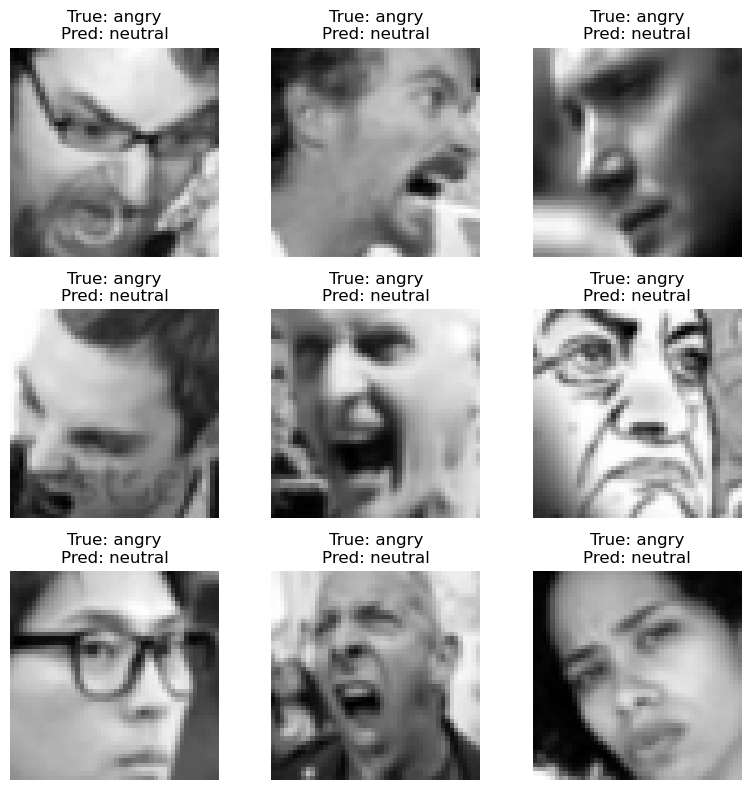

In [89]:
images, labels = next(iter(test_loader))
images, labels = images.to('mps'), labels.to('mps')
outputs = CNN(images)
preds = torch.argmax(outputs, dim=1)
images = images * 0.5 + 0.5
fig, axes = plt.subplots(3, 3, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().squeeze()
    ax.imshow(img, cmap='gray')
    true_label = dataset.classes[labels[i]]
    pred_label = dataset.classes[preds[i]]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [2]:
import torchvision 
import torch
import cv2

model=EmotionCNN()
model.load_state_dict(torch.load("emotion_model.pth",map_location='mps'))
cv2.data

NameError: name 'EmotionCNN' is not defined

In [ ]:
import cv2
model=EmotionCNN()
model.load_state_dict(torch.load("emotion_model.pth",map_location='mps'))


# Load the pre-trained Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

emotion_map = {
    0: ("Angry", "😠"),
    1: ("Disgust", "🤢"),
    2: ("Fear", "😨"),
    3: ("Happy", "😄"),
    4: ("Sad", "😢"),
    5: ("Surprise", "😲"),
    6: ("Neutral", "😐")
}

cap=cv2.VideoCapture(0)
while True:
    ret,frame=cap.read()
    if not ret:break
    frame=cv2.flip(frame,1)
    
    
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray,scaleFactor=1.3,minNeighbors=5)
    face_crop=gray
    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2) # Draw a blue rectangle
        face_crop=gray[y:y+h,x:x+w]
    resized_face=cv2.resize(face_crop,(48,48))

    # Normalize the inputs
    normalized=resized_face/255.0
    normalized=(normalized-0.5)/0.5

    # Convert to tensor of shape (1,1,48,48), 1 channel, 1 batch and 48x48
    tensor_face=torch.tensor(normalized).unsqueeze(0).unsqueeze(0).float()

    # Getting the outputs
    with torch.no_grad():
        output=model(tensor_face)
        pred=torch.argmax(output,1).item()
        prob=torch.softmax(output,1)[0][pred].item()
    
    label,emoji=emotion_map[pred]
    cv2.putText(frame, f"{emoji} {label}", 
            (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)


    # Display the image with detections
    cv2.imshow('Detected Faces', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

: 